# Red Wine Quality Prediction

Dataset source: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

## Project Setup

Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from imblearn.under_sampling import RandomUnderSampler
from matplotlib.colors import TwoSlopeNorm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from xgboost import XGBClassifier

## Data Summarization and Visualization

Load the dataset

In [2]:
df = pd.read_csv("dataset/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Generate the descriptive statistics of the dataset

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


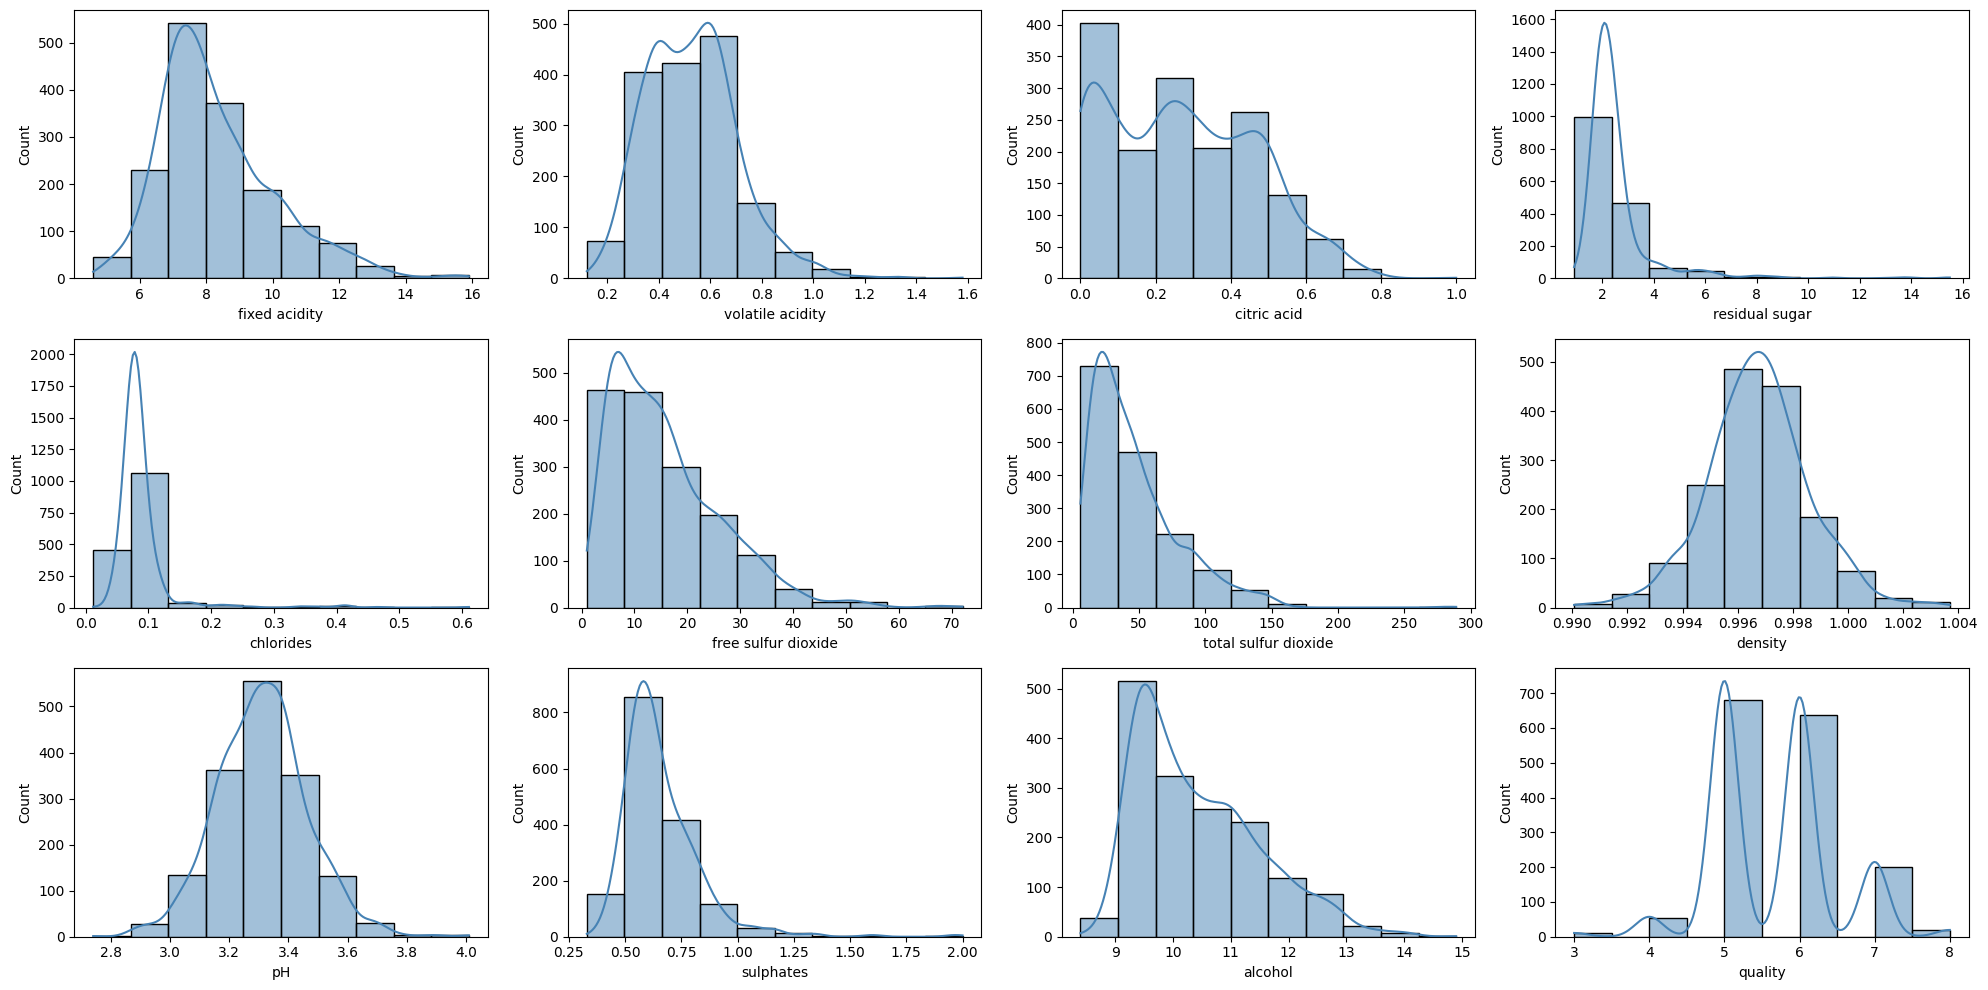

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

features = list(df.columns)

for i in range(3):
    for j in range(4):
        feat = features[i*4 + j]
        sns.histplot(ax=axes[i, j], data=df, x=feat, bins=10, kde=True, color='steelblue')
plt.tight_layout()
plt.show()

Show the correlation matrix

In [6]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


Visualize the correlation matrix

In [7]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_correlations(df):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

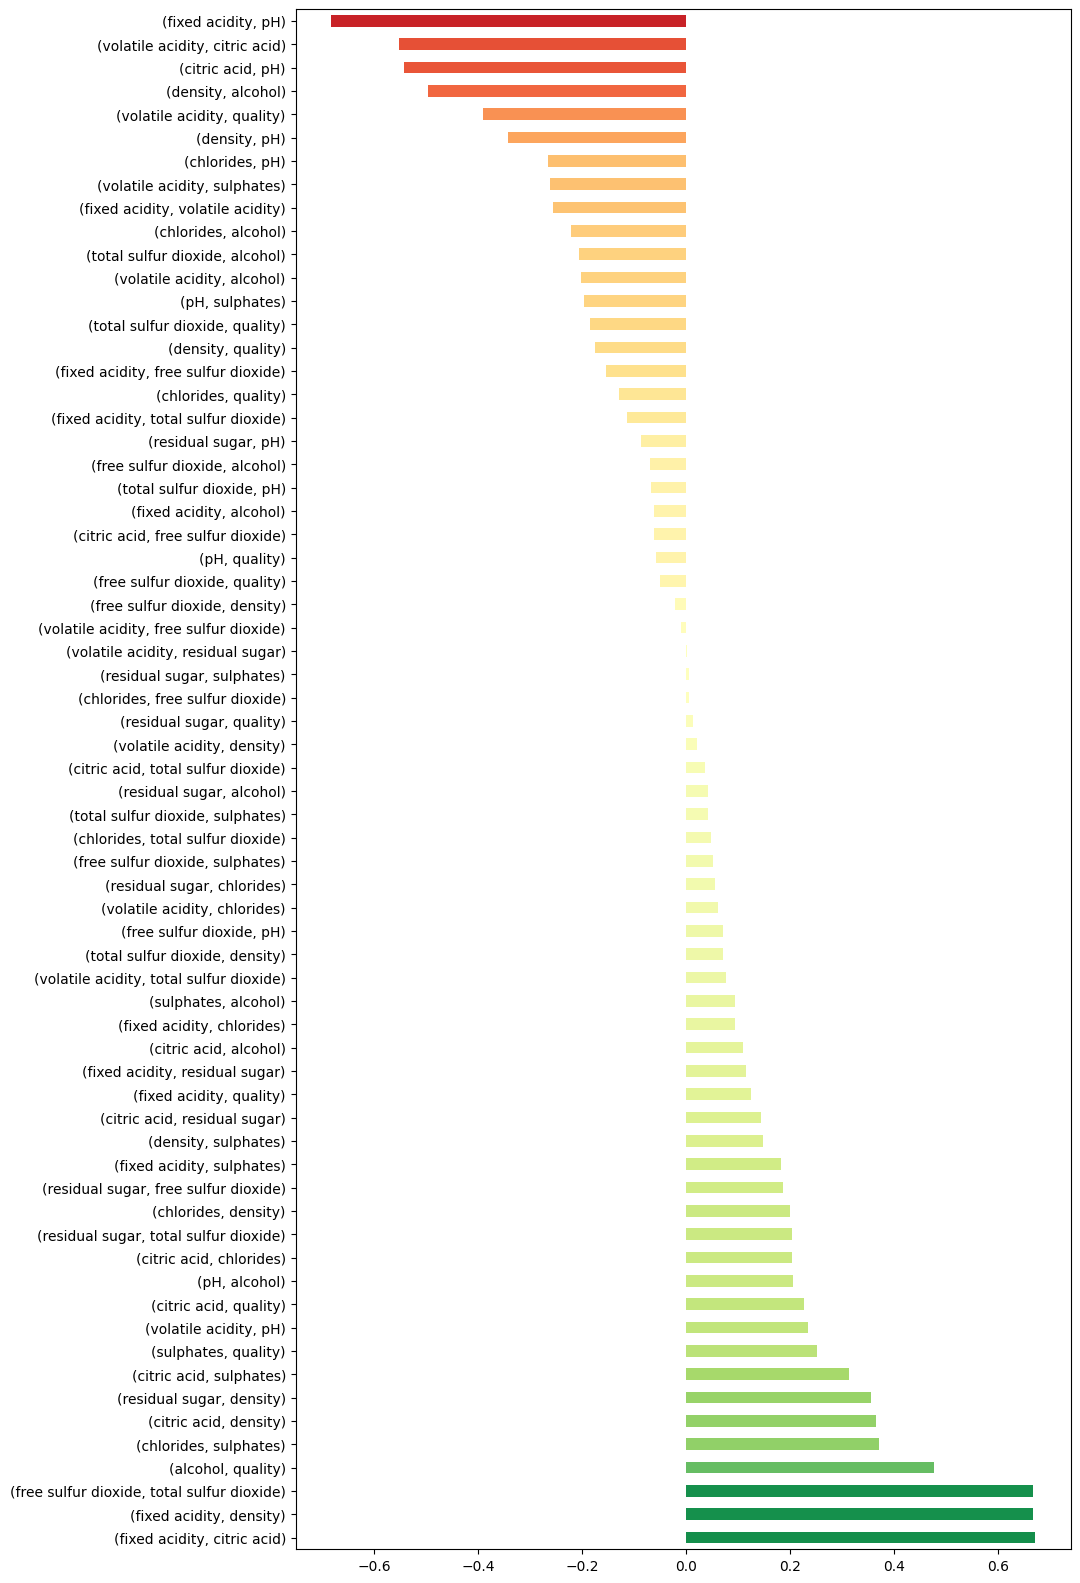

In [8]:
columns = list(df.columns)
correlation_plot = get_correlations(df[columns])

fig = plt.figure(figsize=(10, 20))
norm = TwoSlopeNorm(vmin=-.8, vcenter=0, vmax=.8)
colors = [plt.cm.RdYlGn(norm(c)) for c in correlation_plot.values]
correlation_plot.plot.barh(color=colors)
plt.show()

Visualize the data

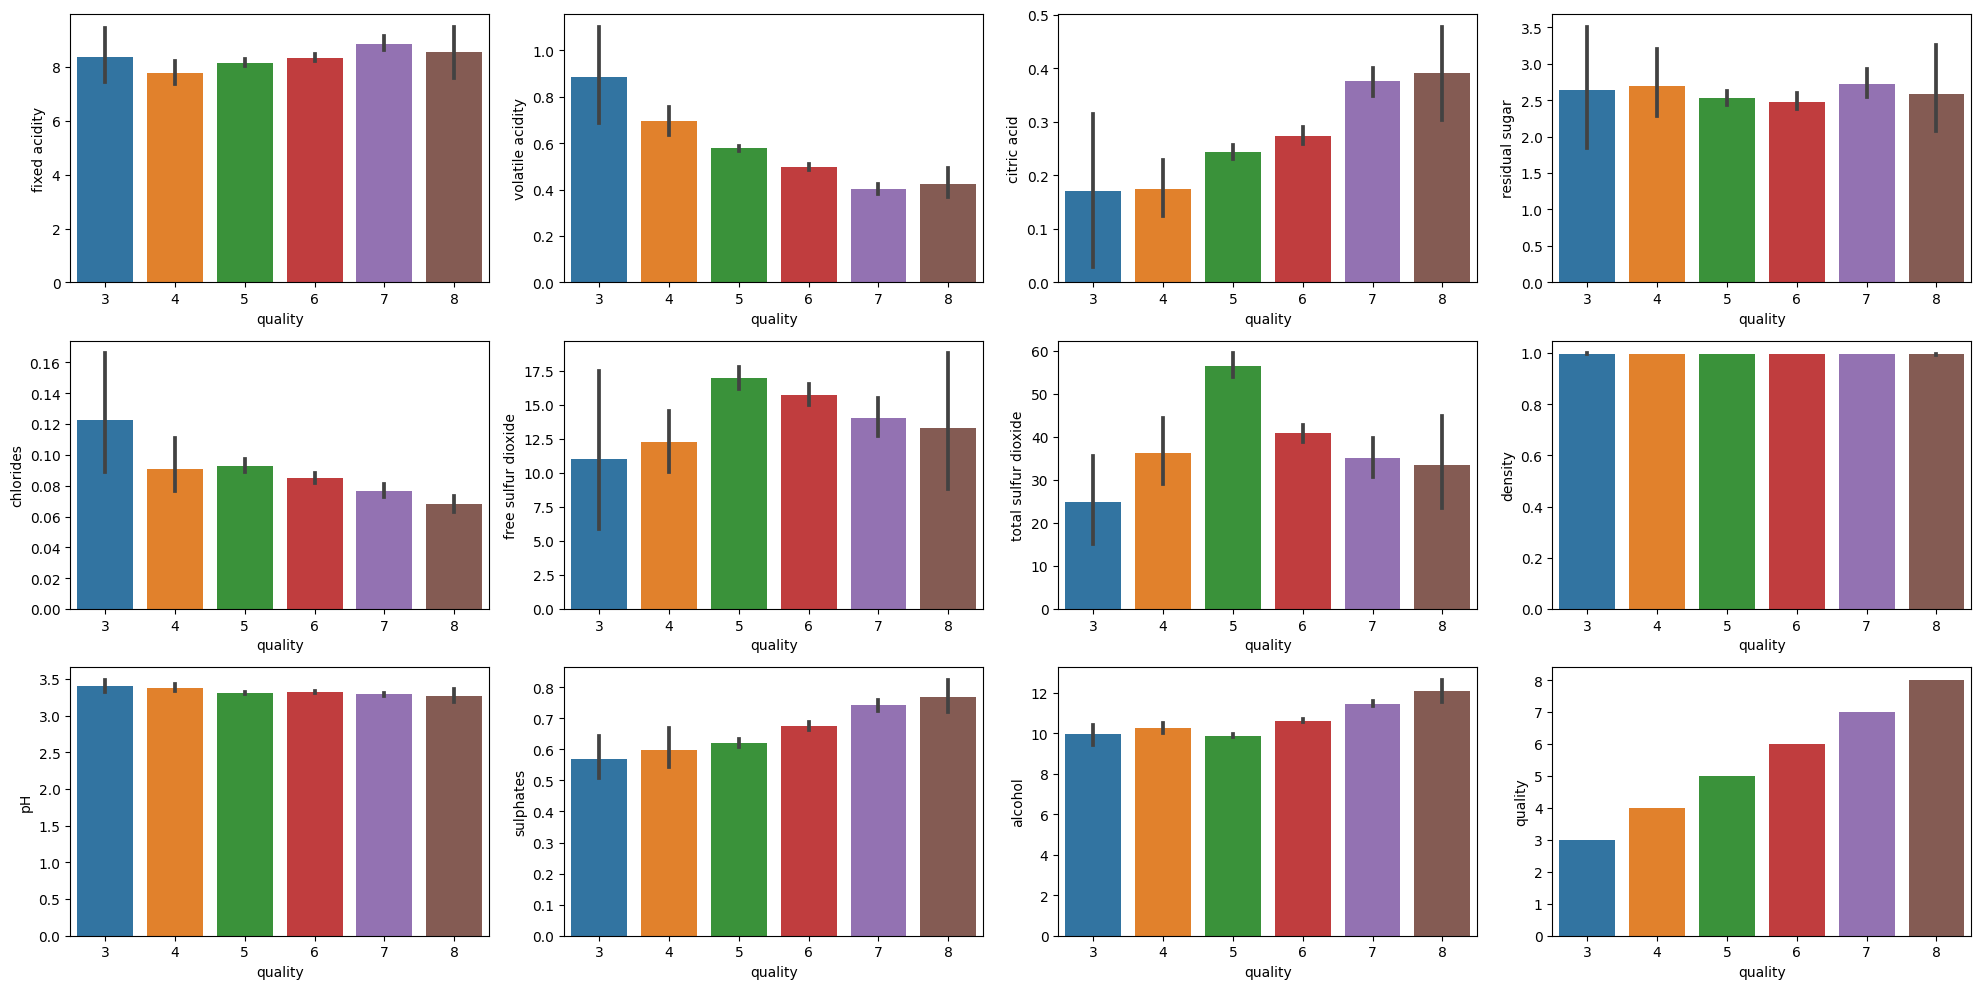

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

features = list(df.columns)

for i in range(3):
    for j in range(4):
        feat = features[i*4 + j]
        sns.barplot(ax=axes[i, j], data=df, x='quality', y=feat)
plt.tight_layout()
plt.show()

Show the class distribution

In [10]:
class_dist = df.groupby("quality").size()

for index, val in class_dist.items():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 3 : 10 samples (0.63%)
Class 4 : 53 samples (3.31%)
Class 5 : 681 samples (42.59%)
Class 6 : 638 samples (39.90%)
Class 7 : 199 samples (12.45%)
Class 8 : 18 samples (1.13%)


Create only two class categories

In [11]:
df["quality"] = [ 1 if x>=7 else 0 for x in df.quality] 
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Show the new class distribution

In [12]:
class_dist = df.groupby("quality").size()

for index, val in class_dist.items():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 1382 samples (86.43%)
Class 1 : 217 samples (13.57%)


We can see that our classes is imbalanced, so we need to perform a data balancing technique later

Split the features and target

In [13]:
X = df.drop(["quality"], axis=1)
y = pd.DataFrame(df["quality"].copy())

Deal with imbalanced classes using random undersampling

In [14]:
random_undersampling = RandomUnderSampler(random_state=42, replacement=True)
X_new, y_new = random_undersampling.fit_resample(X, y)

In [15]:
class_dist = y_new.groupby("quality").size()

for index, val in class_dist.items():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 217 samples (50.00%)
Class 1 : 217 samples (50.00%)


Split the training and testing set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

Perform data scaling using standard scaler

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Training

In [18]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Predict the training set

In [19]:
y_train_pred = clf.predict(X_train)

In [20]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       174

    accuracy                           1.00       347
   macro avg       1.00      1.00      1.00       347
weighted avg       1.00      1.00      1.00       347



Classification report show perfect results, this indicate that the model we build tends to be overfitting. Next we fine-tune using GridSearchCV

## Fine-Tuning the Model

Set the parameter grid for grid search

In [21]:
param_grid={"learning_rate": (0.05, 0.10, 0.15),
            "max_depth": [ 3, 4, 5, 6, 8],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2],
            "colsample_bytree":[ 0.3, 0.4],},

Perform the Grid Search CV

In [22]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid=({'colsample_bytree': [0.3, 0.4],
                          'gamma': [0.0, 0.1, 0.2],
                          'learning_rate': (0.05, 0.1, 0.15),
                          'max_depth': [3, 4, 5, 6, 8],
                          'min_child_weight': [1, 3, 5, 7]},),
             scoring='accuracy')

In [23]:
best_model = grid_search.best_estimator_

In [24]:
y_train_pred = best_model.predict(X_train)

Shows the feature importance

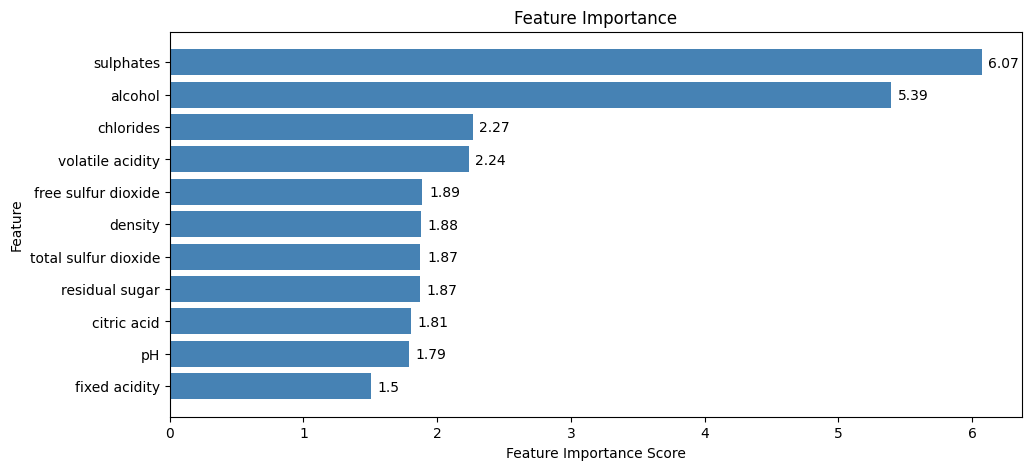

In [25]:
importance_scores = best_model.get_booster().feature_names=list(X.columns)
importance_scores = best_model.get_booster().get_score(importance_type="gain")
importance_scores = {k: v for k, v in sorted(importance_scores.items(), key=lambda item: item[1], reverse=False)}

fig, ax = plt.subplots(figsize=(11,5))
ax.barh(list(importance_scores.keys()), list(importance_scores.values()), color="steelblue")

ax.set_title('Feature Importance')
ax.set_xlabel('Feature Importance Score')
ax.set_ylabel('Feature')

for i, v in enumerate(importance_scores.values()):
    ax.text(v + 0.05, i - 0.15, str(round(v, 2)), color='black')
    
plt.show()

Based on the given importance scores, the most important feature in predicting red wine quality is 'sulphates', with an importance score of 6.07. This is followed by 'alcohol' with an importance score of 5.39, indicating that these two features are the most important for predicting red wine quality.

In [26]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       173
           1       0.97      0.98      0.97       174

    accuracy                           0.97       347
   macro avg       0.97      0.97      0.97       347
weighted avg       0.97      0.97      0.97       347



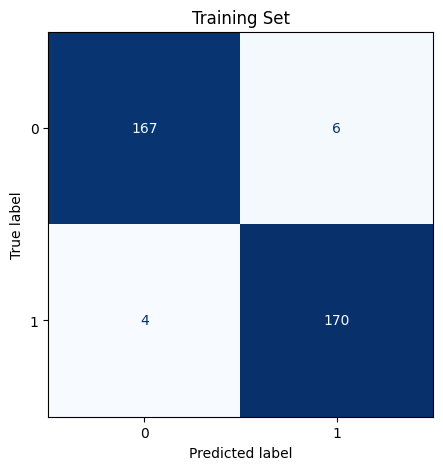

In [27]:
conf_matrix_training = confusion_matrix(y_train, y_train_pred)
conf_mat = ConfusionMatrixDisplay(conf_matrix_training)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Training Set')
conf_mat.plot(cmap="Blues", ax=ax, colorbar=False);

## Model Evaluation

In [28]:
y_test_pred = best_model.predict(X_test)

In [29]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        44
           1       0.85      0.91      0.88        43

    accuracy                           0.87        87
   macro avg       0.88      0.87      0.87        87
weighted avg       0.88      0.87      0.87        87



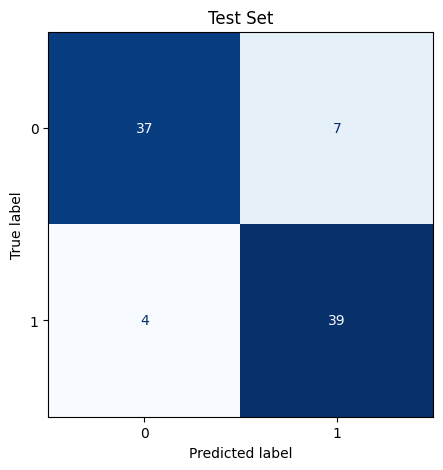

In [30]:
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
conf_mat = ConfusionMatrixDisplay(conf_matrix_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Test Set')
conf_mat.plot(cmap="Blues", ax=ax, colorbar=False);

## Conclusion

In this project we have succeeded in building a model capable of classifying red wine into two classes: good and bad quality. The model is built on the XGBoost model which has been fine-tuned using GridSearchCV. The built model has good predictive ability, as evidenced by the accuracy gain of 0.97 and 0.87 for the training set and testing set, respectively.

#